# Signal resampling 

In [1]:
import seaborn as sns
from scipy import interpolate, signal

from sig import pd, merge_sig_df, Signal

## Signals

49 hz square wave 1 sec long sampled at 0.1 khz and 1 khz, and resampled both ways.

In [2]:
up, dn = 10, 10 ** -1
fs = 100
kw = {"hz": 49, "dur": 1, "waveform": signal.waveforms.square}

# original signals
name_a, name_b = "up then down", "down then up"
sigs = {
    "sig": Signal(name=name_a, fs=fs, **kw),
    "ref": Signal(name=name_b, fs=up * fs, **kw),
}

# resample signals
sigs.update({
    "sup": sigs["sig"].resample(rfactor=up),
    "rdn": sigs["ref"].resample(rfactor=dn),
})

# resample back to original fs
sigs.update({
    "sud": sigs["sup"].resample(rfactor=dn),
    "rdu": sigs["rdn"].resample(rfactor=up),
})

print("\n".join(str(s) for s in sigs.values()))

Signal(fs=   100 hz, waveform=square, hz= 49, dur=1.0, A=1.0, rfactor= 1.0, rwindow=('kaiser', 0.0), bitdepth=float32, name=up then down, provenance=0.1 khz)
Signal(fs= 1,000 hz, waveform=square, hz= 49, dur=1.0, A=1.0, rfactor= 1.0, rwindow=('kaiser', 0.0), bitdepth=float32, name=down then up, provenance=1 khz)
Signal(fs= 1,000 hz, waveform=square, hz= 49, dur=1.0, A=1.0, rfactor=10.0, rwindow=('kaiser', 0.0), bitdepth=float32, name=up then down, provenance=0.1 ↗ 1 khz)
Signal(fs=   100 hz, waveform=square, hz= 49, dur=1.0, A=1.0, rfactor= 0.1, rwindow=('kaiser', 0.0), bitdepth=float32, name=down then up, provenance=1 ↘ 0.1 khz)
Signal(fs=   100 hz, waveform=square, hz= 49, dur=1.0, A=1.0, rfactor= 0.1, rwindow=('kaiser', 0.0), bitdepth=float32, name=up then down, provenance=1 ↘ 0.1 khz)
Signal(fs= 1,000 hz, waveform=square, hz= 49, dur=1.0, A=1.0, rfactor=10.0, rwindow=('kaiser', 0.0), bitdepth=float32, name=down then up, provenance=0.1 ↗ 1 khz)


## Result

In [3]:
df = merge_sig_df(sigs.values())
print(df.head().drop(columns=["name", "wave"]))

   rcount      omega provenance  dur      t wfkwargs fs_khz    fs resampled fs_beg  hz waveform  rfactor    A bitdepth        rwindow signal    y
0       0  307.87608      1 khz    1  0.000       {}  1 khz  1000    [1000]  1 khz  49   square      1.0  1.0  float32  (kaiser, 0.0)      y  1.0
1       0  307.87608      1 khz    1  0.000       {}  1 khz  1000    [1000]  1 khz  49   square      1.0  1.0  float32  (kaiser, 0.0)  error  NaN
2       0  307.87608      1 khz    1  0.001       {}  1 khz  1000    [1000]  1 khz  49   square      1.0  1.0  float32  (kaiser, 0.0)      y  1.0
3       0  307.87608      1 khz    1  0.001       {}  1 khz  1000    [1000]  1 khz  49   square      1.0  1.0  float32  (kaiser, 0.0)  error  NaN
4       0  307.87608      1 khz    1  0.002       {}  1 khz  1000    [1000]  1 khz  49   square      1.0  1.0  float32  (kaiser, 0.0)      y  1.0


### Plot helpers

In [4]:
pad = 5 * " "
p = "pastel"
palette = lambda df, c, p: sns.color_palette(p, df[c].nunique())
set_title = lambda name, ax: ax.set_title(f"{name}\n\n{ax.get_title()}")
fmt_title = lambda g: [ax.set_title(ax.get_title().replace(" | ", f"{pad}|{pad}")) for axes in g.axes for ax in axes]
hue = "fs_khz"
plot_kws = {
    "x": "t",
    "y": "y",
    "hue": hue,
    "col": "signal",
    "row": "provenance",
    "kind": "line",
    "height": 2.6,
    "aspect": 3.6,
    "estimator": None,
    "facet_kws": {"sharey": False},
}

### Resample up then down

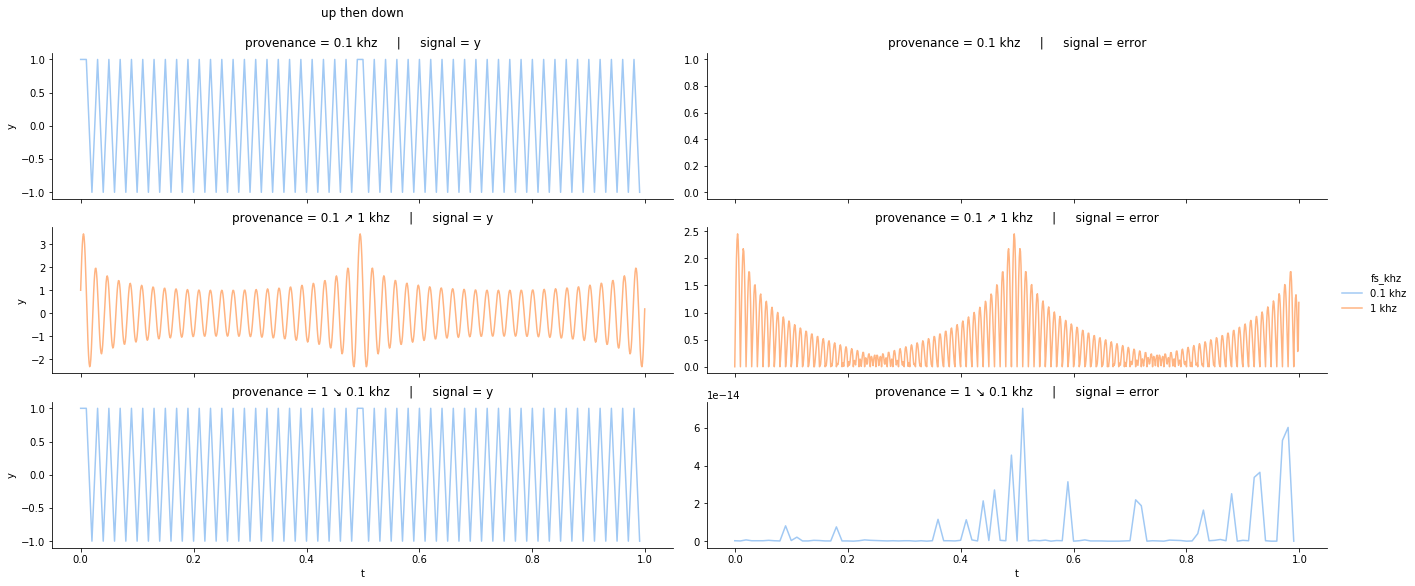

In [5]:
pdf = df[df.name == name_a]
g = sns.relplot(data=pdf, palette=palette(pdf, hue, p), **plot_kws)
_ = set_title(name_a, g.axes[0][0])
_ = fmt_title(g)

### Resample down then back up

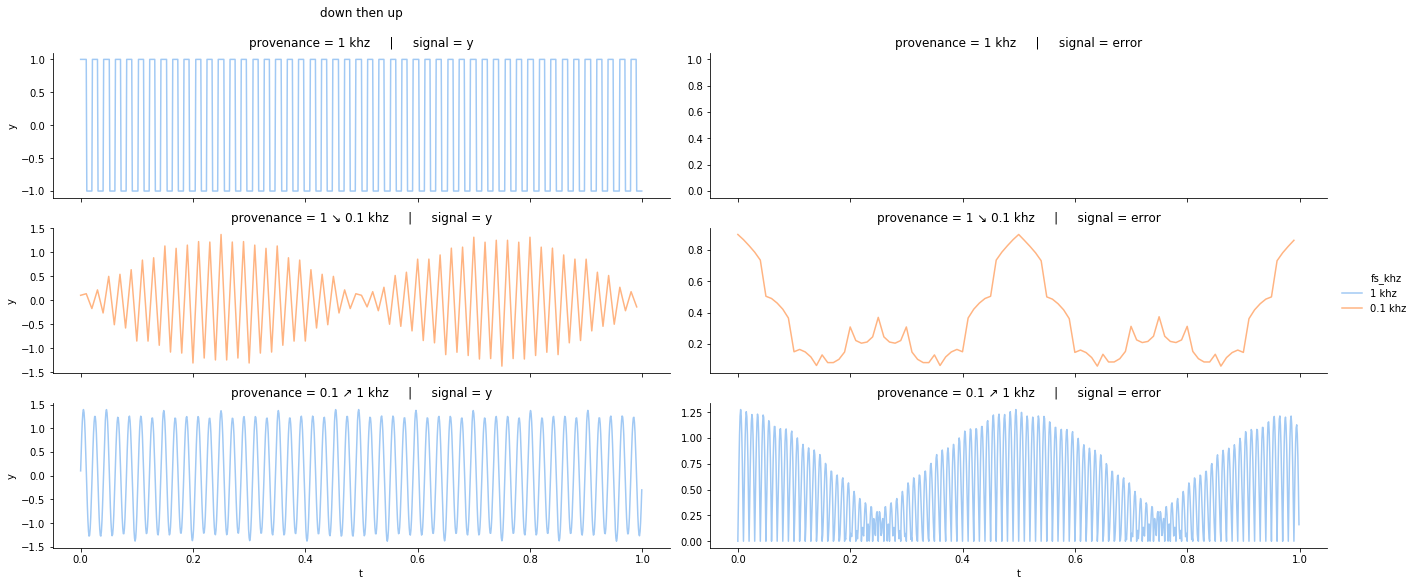

In [6]:
pdf = df[df.name == name_b]
g = sns.relplot(data=pdf, palette=palette(pdf, hue, p), **plot_kws)
_ = set_title(name_b, g.axes[0][0])
_ = fmt_title(g)

# FFT Magnitude Spectrum

## Generate signals

In [7]:
from scipy.signal import waveforms, windows  # type: ignore
from sig import fmt_fft_plot, Signal

# signals
fs = 48_000
sigs = [
    Signal(fs=fs, hz=110, dur=2, A=0.8, waveform=waveforms.square),
    Signal(fs=fs, hz=220, dur=2, A=0.9, waveform=waveforms.sin),
    Signal(fs=fs, hz=440, dur=2, A=0.9, waveform=waveforms.sin),
    Signal(fs=fs, hz=520, dur=2, A=0.9, waveform=waveforms.square),
    Signal(fs=fs, hz=720, dur=2, A=0.6, waveform=waveforms.sin),
    Signal(fs=fs, hz=1240, dur=2, A=0.7, waveform=waveforms.sawtooth),
]

## FFT and dataframe

### Dataframe helpers

In [8]:
import pandas as pd

filt_freq = lambda df, minf, maxf: df[(df.freq >= minf) & (df.freq <= maxf)]
unq = lambda x: x.unique().tolist()
getf0 = lambda df: sep_df.f0_gt.str.replace(",", "").astype(int)
flatten_cols = lambda df: ["_".join(c) if c[1] != "first" else c[0] for c in df.columns]

In [9]:
# dataframe aggregation variables
m, f, s, mm = "max", "first", "sum", ["min", "max"]
sort = ["omega", "bin"]
mixgrp = ["bin", "freq"]
mixagg = {"mag": s, "mag_clip": s, "real": s, "imag": s, "fsize": f, "omega": lambda x: unq(x)}
sumgrp = ["wave", "f0_gt", "A", "omega"]
sumagg = {"f0_est": f, "mag": m, "real": m, "imag": m, "bin": mm, "freq": mm, "fsize": f}

### Compute FFT

In [10]:
fsize = 2 ** 12
win = windows.kaiser(fsize, beta=7.0)
sep_df = pd.concat(s.fft_df(s=fsize, win=win) for s in sigs).reset_index(drop=True).sort_values(by=sort)
mix_df = sep_df.round(2).groupby(mixgrp).agg(mixagg).reset_index()

## Plot

### Plot helpers

In [11]:
import seaborn as sns

x, y, hue, p = "freq", "mag_clip", "wave", "pastel"
plot_kws = {
    "x": x, "y": y, "hue": hue, "col": hue, "col_wrap": 2, "kind": "line", "height": 2.0, "aspect": 3.8, "estimator": None, "lw": 1.5,
}
minf = getf0(sep_df).min() * 2 ** -1
maxf = getf0(sep_df).max() * 2 ** 3
xy_scale = lambda g, x, y: [(ax.set_xscale(x), ax.set_yscale(y)) for ax in (g.axes if hasattr(g.axes[0], "set_yscale") else g.axes[0])]

### Each signal

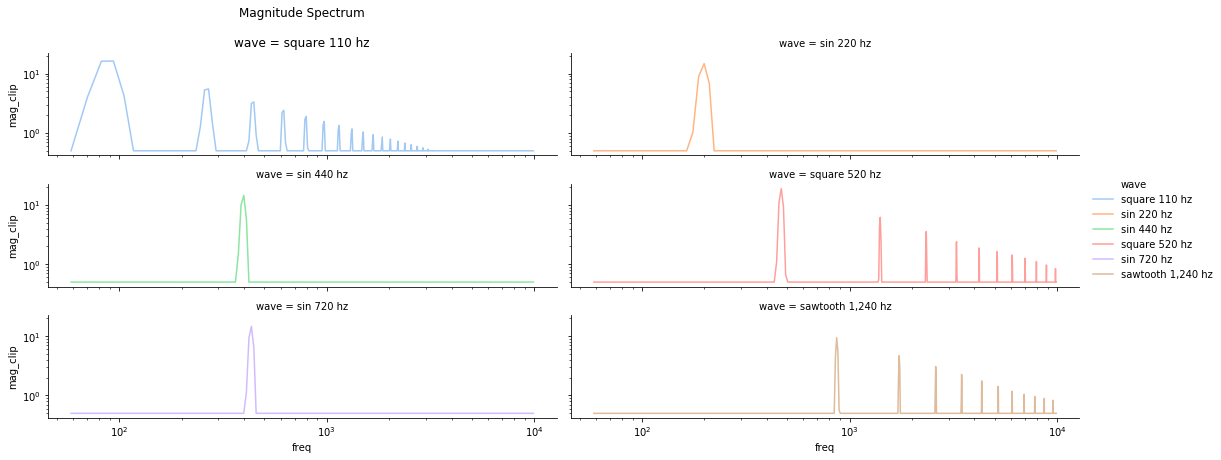

In [12]:
pdf = filt_freq(sep_df, minf, maxf)
g = sns.relplot(data=pdf, palette=palette(pdf, hue, p), **plot_kws)
_ = set_title("Magnitude Spectrum", g.axes[0] if hasattr(g.axes[0], "set_title") else g.axes[0][0])
_ = xy_scale(g, "log", "log")

### Mixture

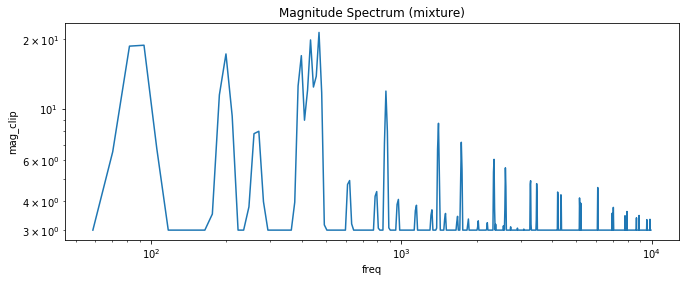

In [13]:
ax = sns.lineplot(x=x, y=y, data=filt_freq(mix_df, minf, maxf), estimator=None)
ax = fmt_fft_plot(ax, yscale="log", xscale="log", title="Magnitude Spectrum (mixture)", size=(11, 4))

### Summary

In [14]:
summ_df = sep_df.round(1).groupby(sumgrp).agg(sumagg)
summ_df.columns = flatten_cols(summ_df)
print(summ_df)

                                    f0_est  mag_max  real_max  imag_max  bin_min  bin_max  freq_min  freq_max  fsize
wave              f0_gt A   omega                                                                                   
sawtooth 1,240 hz 1,240 0.7 7791.1   867.2      9.4       1.3       9.2        0     2048       0.0   24000.0   4096
sin 220 hz        220   0.9 1382.3   199.2     14.8       2.9       8.5        0     2048       0.0   24000.0   4096
sin 440 hz        440   0.9 2764.6   398.4     14.5       6.1       8.0        0     2048       0.0   24000.0   4096
sin 720 hz        720   0.6 4523.9   433.6     14.7       3.9       8.5        0     2048       0.0   24000.0   4096
square 110 hz     110   0.8 691.2     93.8     16.3      16.2       0.5        0     2048       0.0   24000.0   4096
square 520 hz     520   0.9 3267.3   468.8     18.9       2.4      10.7        0     2048       0.0   24000.0   4096
